Features: Year + Total
# Intro

Consider a model with 2 features

$$
f(t) = f_1(t_1)+f_2(t_2),\\
f_1\sim GP(0, K1), \\
f_2\sim GP(0, K2)
$$
where $t_1\in[0,1]$ and $t_2\in[0,1]$, and while $t_1$ corresponds to observed rescaled time, $t_2$ is within 1 regularised year (52 weeks). We will model both with squared exponential GPs.

**Outcome:**
1. Should standardise responses really
2. Should add more features: 
3. Need get rid of outliers: try stumpy


In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import pandas as pd

In [2]:
import jax
from jax import vmap, jit

In [3]:
import jax.numpy as np
import jax.random as random

In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

# Constants

In [84]:
dt_year = 0.11070559610705594

# Funs

In [6]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """
    Return covariance matrix of size X x Z
    """
    deltaXsq = np.power((X[:, None] - Z) / length, 2.0) # raise matrix X-Z to power 2.0
    k = var * np.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * np.eye(X.shape[0])
    return k

In [7]:
sq_exp = lambda x, y, l, v: v*np.exp(-.5*np.power((x-y)/l,2))

In [8]:
# squared exponential kernel with diagonal noise term
def cov_matr(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """
    Return covariance matrix of size X x Z
    """
    with_noise = lambda X, Z: cov_map(partial(sq_exp, l = length, v = var), X, Z) + (noise + jitter) * np.eye(X.shape[0], Z.shape[0])
    without_noise = lambda X, Z: cov_map(partial(sq_exp, l = length, v = var), X, Z)
    
    return cond(include_noise, with_noise, without_noise, X, Z)

In [9]:
# squared exponential kernel with diagonal noise term
def cov_matr(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """
    Return covariance matrix of size X x Z
    """
    
    return cov_map(partial(sq_exp, l = length, v = var), X, Z) + \
                (noise*include_noise + jitter) * np.eye(X.shape[0], Z.shape[0])

In [11]:
def model(X, Y):
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )

In [12]:
# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = np.linalg.inv(k_XX)
    K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
    sigma_noise = np.sqrt(np.clip(np.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1])
    mean = np.matmul(k_pX, np.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [99]:
def model2(X1, Y):
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var1 = numpyro.sample("kernel_var1", dist.LogNormal(0.0, 10.0))
    noise1 = numpyro.sample("kernel_noise1", dist.LogNormal(0.0, 10.0))
    length1 = numpyro.sample("kernel_length1", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k1 = kernel(X1, X1, var1, length1, noise1)

    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var2 = numpyro.sample("kernel_var2", dist.LogNormal(0.0, 10.0))
    noise2 = numpyro.sample("kernel_noise2", dist.LogNormal(0.0, 10.0))
    length2 = numpyro.sample("kernel_length2", dist.LogNormal(0.0, 10.0))

    # compute kernel
    X2 = X1/dt_year-(X1//dt_year)
    k2 = kernel(X2, X2, var2, length2, noise2)

    
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k1+k2),
        obs=Y,
    )

In [187]:
def model2a(X1, Y):
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var1 = numpyro.sample("kernel_var1", dist.LogNormal(0.0, 10.0))
    noise1 = numpyro.sample("kernel_noise1", dist.LogNormal(0.0, 10.0))
    length1 = numpyro.sample("kernel_length1", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k1 = kernel(X1, X1, var1, length1, noise1)

    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var2 = numpyro.sample("kernel_var2", dist.LogNormal(0.0, 10.0))
    noise2 = numpyro.sample("kernel_noise2", dist.LogNormal(0.0, 10.0))
    length2 = numpyro.sample("kernel_length2", dist.LogNormal(0.0, 10.0))

    # compute kernel
    X2 = X1/dt_year-(X1//dt_year)
    k2 = kernel(X2, X2, var2, length2, noise2)

    N = Y.size
    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y",
       dist.TransformedDistribution(dist.Normal().expand([N]),
                                    dist.transforms.LowerCholeskyAffine(np.zeros(N),
                                                                        np.linalg.cholesky(k1+k2))), 
       obs = Y)

In [409]:
def predict0(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = np.linalg.inv(k_XX)
    K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
    
    mean = np.matmul(k_pX, np.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, K

In [116]:
def predict2(rng_key, X1, Y, X_test1, var1, length1, noise1, var2, length2, noise2):
    
    mean1, K1 = predict0(rng_key, X1, Y, X_test1, var1, length1, noise1)
    
    X2 = X1/dt_year-(X1//dt_year)
    X_test2 = X_test1/dt_year-(X_test1//dt_year)
    mean2, K2 = predict0(rng_key, X2, Y, X_test2, var2, length2, noise2)
    
    mean = mean1+mean2
    sigma_noise = np.sqrt(np.clip(np.diag(K1+K2), a_min=0.0)) * jax.random.normal(
        rng_key, X_test1.shape[:1])
        
        
        
    return mean, mean + sigma_noise

In [149]:
# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict2(rng_key, X1, Y, X_test1, var1, length1, noise1, var2, length2, noise2):
    # compute kernels between train and test data, etc.
    # k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    # k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    # k_XX = kernel(X, X, var, length, noise, include_noise=True)
    # K_xx_inv = np.linalg.inv(k_XX)
    # K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
    
    def comp_ker(rng_key, X, Y, X_test, var, length, noise):
        k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
        k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
        k_XX = kernel(X, X, var, length, noise, include_noise=True)
        
        return k_pp, k_pX, k_XX
    
    k_pp1, k_pX1, K_XX1 = comp_ker(rng_key, X1, Y, X_test1, var1, length1, noise1)
    
    X2 = X1/dt_year-(X1//dt_year)
    X_test2 = X_test1/dt_year-(X_test1//dt_year)
    k_pp2, k_pX2, K_XX2 = comp_ker(rng_key, X2, Y, X_test2, var2, length2, noise2)
    
    
    K_xx_inv = np.linalg.inv(K_XX1+K_XX2)
        
    K = k_pp1+k_pp2 - np.matmul(k_pX1+k_pX2, np.matmul(K_xx_inv, np.transpose(k_pX1+k_pX2)))
    mean = np.matmul(k_pX1+k_pX2, np.matmul(K_xx_inv, Y))
    
    
    sigma_noise = np.sqrt(np.clip(np.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test1.shape[:1])
    
    
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [13]:
# helper function for doing hmc inference
def run_inference(model, args, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if args['init_strategy'] == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif args['init_strategy'] == "median":
        init_strategy = init_to_median(num_samples=10)
    elif args['init_strategy'] == "feasible":
        init_strategy = init_to_feasible()
    elif args['init_strategy'] == "sample":
        init_strategy = init_to_sample()
    elif args['init_strategy'] == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args['num_warmup'],
        num_samples=args['num_samples'],
        num_chains=args['num_chains'],
        thinning=args['thinning'],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

In [14]:
# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = np.linspace(-1, 1, N)
    Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y += sigma_obs * onp.random.randn(N)
    # standardize Y
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = np.linspace(-2., 2., N_test)

    return X, Y, X_test

In [34]:
# num_data = 25
# X, Y, X_test = get_data(N=num_data)

In [30]:
# load csv
df = pd.read_csv('Data/Ozone_time_series.csv')
df;

In [196]:
# X = df['reg_year_dtab'].to_numpy()[::5]
X = df['dtab'].to_numpy()[::4]


Y = df['x'].to_numpy()[::4]
Y = (Y-Y.mean())/Y.std()



X_test = np.linspace(0., 1., 300)
# X_test = X

X2 = X/dt_year-(X//dt_year)
X_test2 = X_test/dt_year-(X_test//dt_year)

In [425]:
X2

array([0.09822955, 0.10091384, 0.10309829, 0.10374695, 0.10538385,
       0.10584554, 0.10647512, 0.11178839, 0.11953411, 0.12053571,
       0.12215545, 0.12455739, 0.12847604, 0.13621986, 0.14220085,
       0.14461042, 0.15009348, 0.15048077, 0.1556147 , 0.16622596,
       0.17171284, 0.17445627, 0.18271139, 0.18332189, 0.1888927 ,
       0.22442575, 0.25413805, 0.25687958, 0.26237599, 0.67191316,
       0.68289263, 0.68572955, 0.68838523, 0.69373474, 0.69643048,
       0.6992674 , 0.70194025, 0.70238477, 0.70485539, 0.7078602 ,
       0.71053877, 0.72411287, 0.72665408, 0.72960165, 0.73232792,
       0.73493208, 0.74331311, 0.74605082, 0.74853861, 0.75416476,
       0.76495726, 0.76565553, 0.76828259, 0.77947001, 0.7895757 ,
       0.80099397, 0.80418002, 0.80877976, 0.80969551, 0.83396864,
       0.83654418, 0.84222184, 0.84453411, 0.8452381 , 0.84727564,
       0.85852984, 0.86093368, 0.86368475, 0.86470543, 0.86986035,
       0.87028007, 0.8726076 , 0.88977411, 0.89664797, 0.90264

In [173]:
# delme1 = df['reg_year_dtab'].to_numpy()[::5]

In [174]:
# delme = X/dt_year-(X//dt_year)

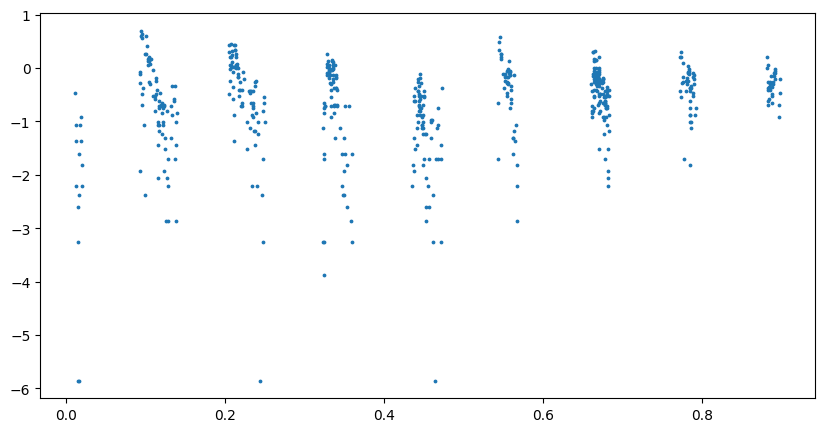

In [215]:
plt.figure(figsize=(10, 5))
plt.scatter(X, np.log(Y), 3)

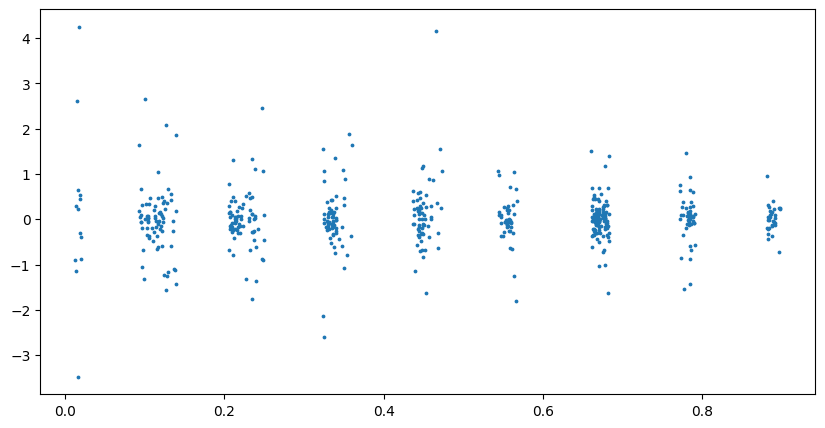

In [217]:
plt.figure(figsize=(10, 5))
plt.scatter(X[1:], np.diff(np.log(Y)), 3)

In [198]:
X.shape, Y.shape

((847,), (847,))

In [201]:
%time
args = {'init_strategy': 'feasible', 
        'num_samples': 1000, 
        'num_warmup': 100, 
        'num_chains': 1,
        'device': 'cpu',
        'thinning': 2,
        }

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model2a, args, rng_key, X, Y)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 11 µs


sample: 100%|█| 1100/1100 [22:39<00:00,  1.24s/it, 63 steps of size 4.43e-02. ac



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length1      0.00      0.00      0.00      0.00      0.00    268.18      1.00
  kernel_length2      0.10      0.02      0.10      0.07      0.14    216.71      1.00
   kernel_noise1      0.02      0.01      0.03      0.00      0.04     99.25      1.00
   kernel_noise2      0.01      0.01      0.00      0.00      0.03     98.35      1.00
     kernel_var1      0.23      0.03      0.22      0.18      0.26    260.33      1.00
     kernel_var2      1.32      1.83      0.89      0.24      2.46    352.54      1.00

Number of divergences: 20

MCMC elapsed time: 1359.476040840149


In [202]:
samples['kernel_length1'].mean(), samples['kernel_length2'].mean()

(DeviceArray(0.00133089, dtype=float32),
 DeviceArray(0.10346517, dtype=float32))

In [222]:
import dill

In [140]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var2"].shape[0]),
     samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)
means, predictions = vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X2, Y, X_test2, var, length, noise
    )
)(*vmap_args)

mean_prediction = onp.mean(means, axis=0)
percentiles = onp.percentile(predictions, [5.0, 95.0], axis=0)

CPU times: user 14.2 s, sys: 7.17 s, total: 21.3 s
Wall time: 5.72 s


In [203]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"],
    samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)
means, predictions = vmap(
    lambda rng_key, var1, length1, noise1, var2, length2, noise2: predict2(
        rng_key, X, Y, X_test, var1, length1, noise1, var2, length2, noise2
    )
)(*vmap_args)

mean_prediction = onp.mean(means, axis=0)
percentiles = onp.percentile(predictions, [5.0, 95.0], axis=0)

CPU times: user 1min 30s, sys: 45.8 s, total: 2min 15s
Wall time: 37.9 s


In [207]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"],
    samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)
means, predictions = vmap(
    lambda rng_key, var1, length1, noise1, var2, length2, noise2: predict2(
        rng_key, X, Y, X, var1, length1, noise1, var2, length2, noise2
    )
)(*vmap_args)

mean_prediction1 = onp.mean(means, axis=0)
percentiles1 = onp.percentile(predictions, [5.0, 95.0], axis=0)

CPU times: user 2min 24s, sys: 2min 17s, total: 4min 41s
Wall time: 1min 15s


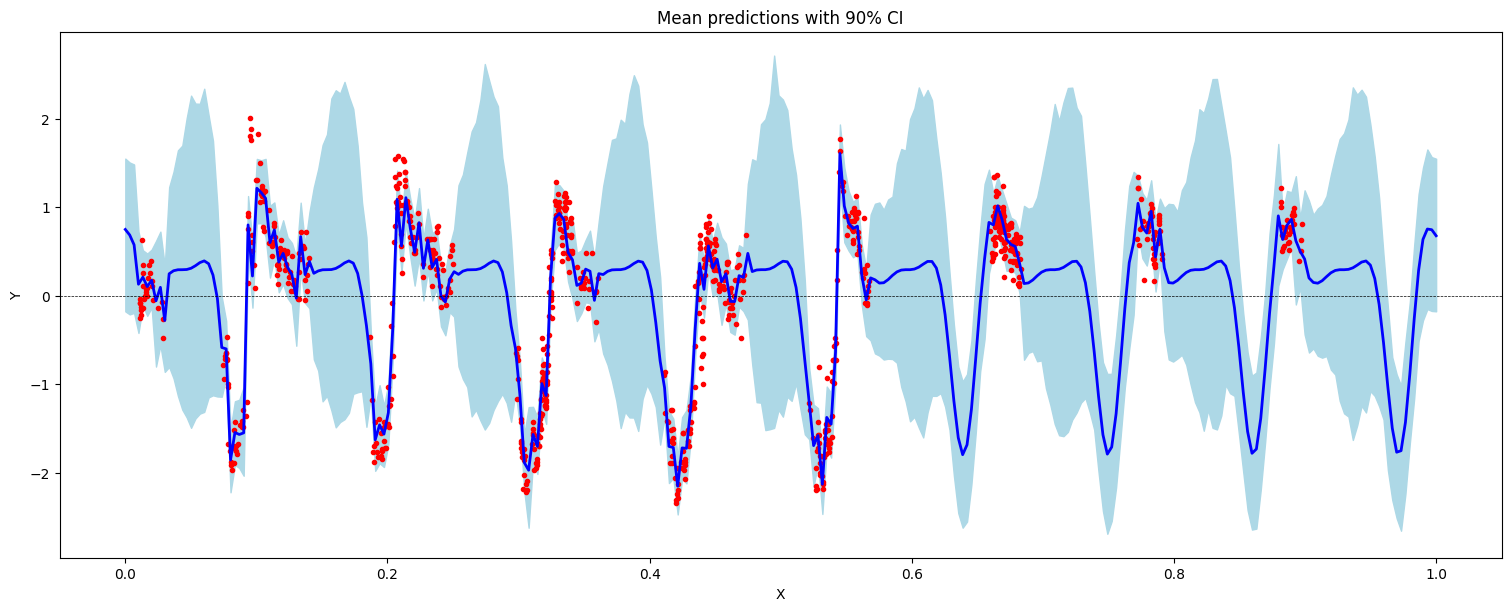

In [208]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

ax.axhline(0, linestyle = '--', color = 'k', linewidth = '.5')

Text(0, 0.5, '${Standardised \\; Ozone}_{CD}$')

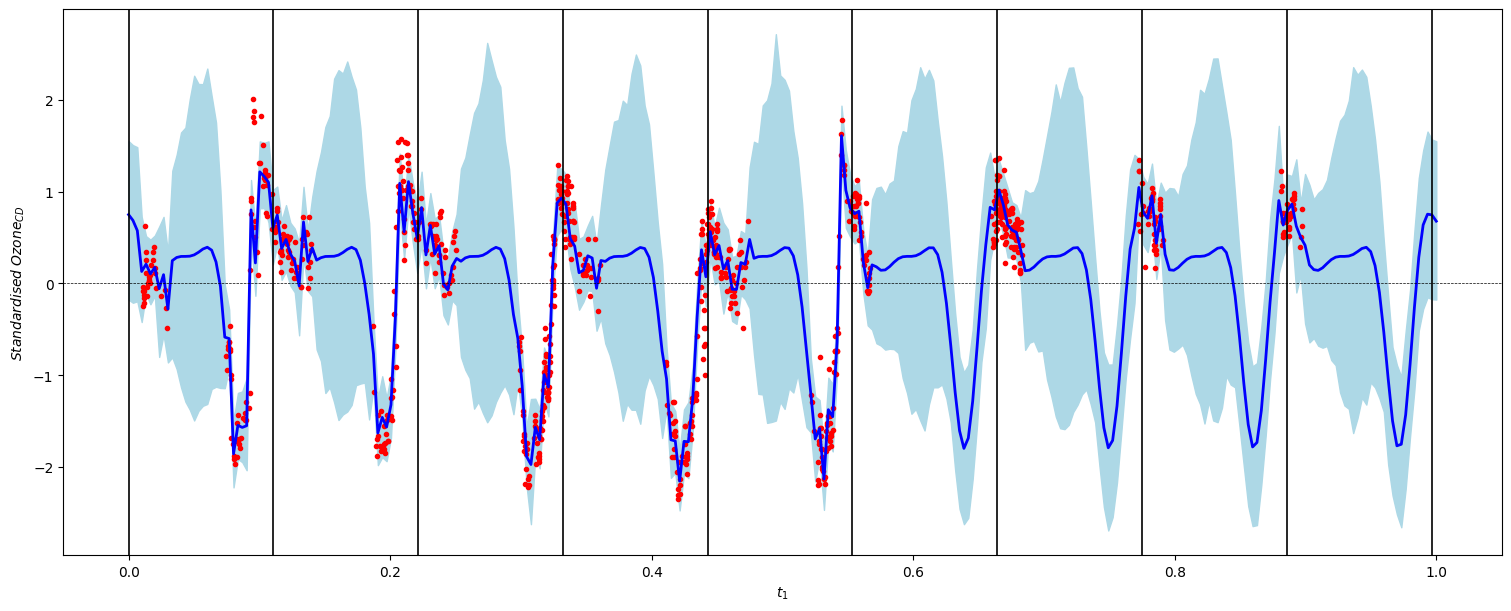

In [401]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y");

ax.axhline(0, linestyle = '--', color = 'k', linewidth = '.5')

for x in np.arange(0, 1., dt_year):
    ax.axvline(x, color = 'black', linestyle = '-', linewidth = 1.2)
    
ax.set_xlabel('$t_1$')
ax.set_ylabel('${Standardised \; Ozone}_{CD}$')

In [455]:
with open('mcmc_model1a.pkl', 'wb') as dill_file:
    dill.dump((samples, mean_prediction, percentiles, X, Y, X_test, dt_year), dill_file)

Text(0, 0.5, 'Residuals')

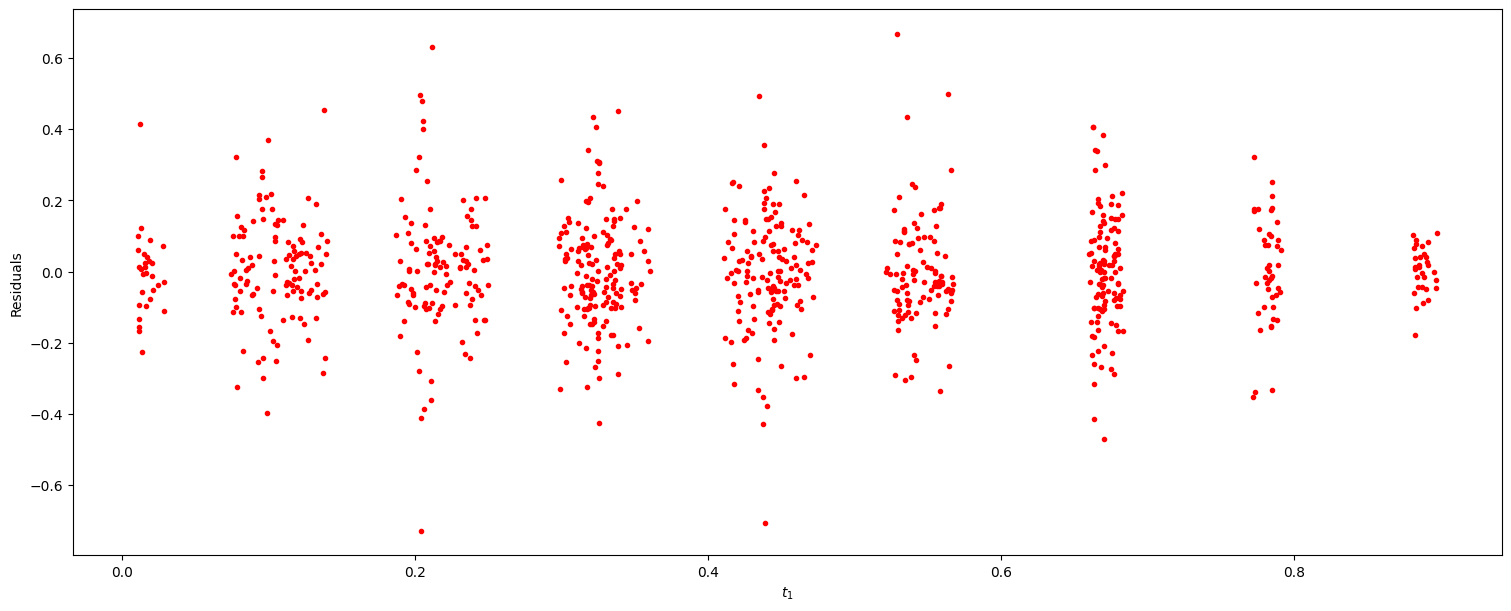

In [405]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y-mean_prediction1, "r.")
# plot 90% confidence level of predictions
# ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
# ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)

ax.set_xlabel('$t_1$')
ax.set_ylabel('Residuals')

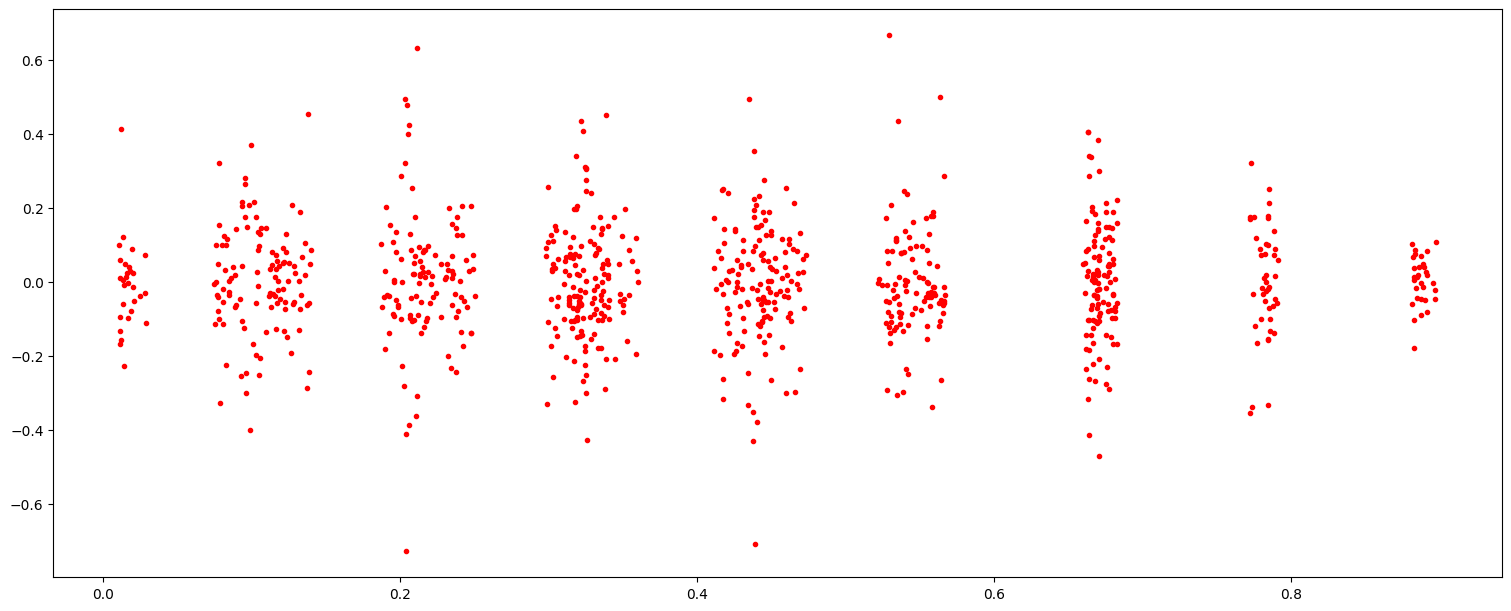

In [209]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y-mean_prediction1, "r.")
# plot 90% confidence level of predictions
# ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
# ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)

ax.set_xlabel('$t_1$')
ax.set_ylabel('Residuals')

In [219]:
np.mean(Y-mean_prediction1), np.std(Y-mean_prediction1), 

(DeviceArray(-1.2724817e-05, dtype=float32),
 DeviceArray(0.15317681, dtype=float32))

In [231]:
# X_test

# Analyse model

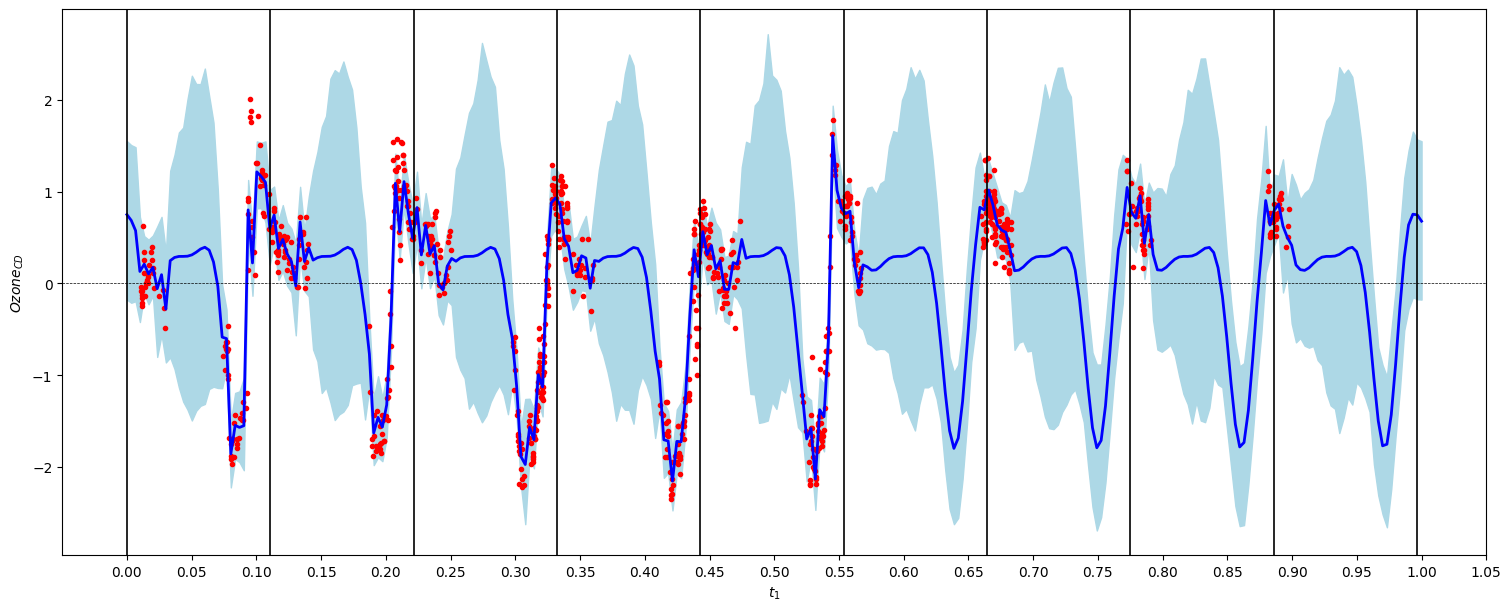

In [398]:

# make plots

fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y");

ax.axhline(0, linestyle = '--', color = 'k', linewidth = '.5')



for x in np.arange(0, 1., dt_year):
    ax.axvline(x, color = 'black', linestyle = '-', linewidth = 1.2)
    
ax.set_xticks(np.arange(0.,1.1,.05));
ax.set_xlabel('$t_1$')
ax.set_ylabel('${Ozone}_{CD}$');

### Overall trend

In [415]:
dt_year

0.11070559610705594

In [416]:
samples["kernel_length2"].mean()

DeviceArray(0.10346517, dtype=float32)

In [411]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"]
)

means_t1, predictions_t1 = vmap(
    lambda rng_key, var1, length1, noise1: predict(
        rng_key, X, Y, X_test, var1, length1, noise1,
    )
)(*vmap_args)

mean_prediction_t1 = onp.mean(means_t1, axis=0)
percentiles_t1 = onp.percentile(predictions_t1, [5.0, 95.0], axis=0)

CPU times: user 1min 11s, sys: 31.6 s, total: 1min 43s
Wall time: 25.8 s


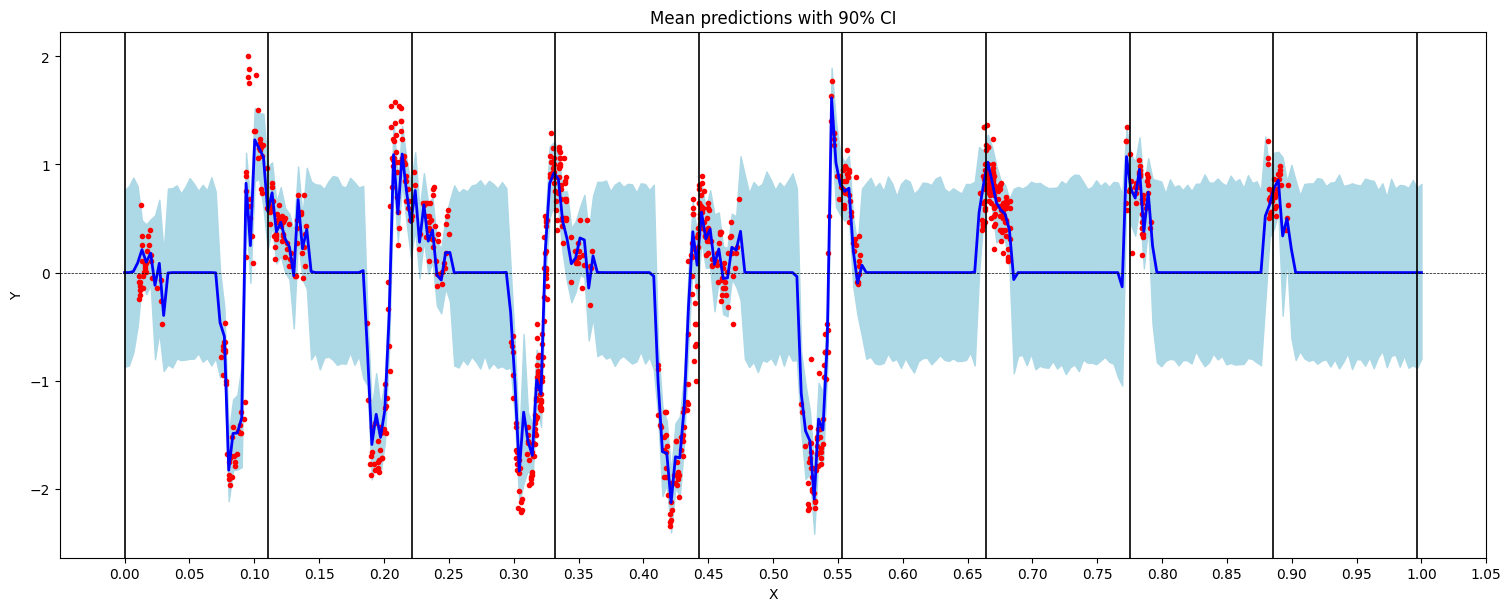

In [413]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles_t1[0, :], percentiles_t1[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction_t1, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

ax.axhline(0, linestyle = '--', color = 'k', linewidth = '.5')



for x in np.arange(0, 1., dt_year):
    ax.axvline(x, color = 'black', linestyle = '-', linewidth = 1.2)
    
ax.set_xticks(np.arange(0.,1.1,.05));


In [436]:
l1 = samples['kernel_length1'].mean()
v1 = samples['kernel_var1'].mean()
n1 = samples['kernel_noise1'].mean()

In [437]:
key1, key2 = random.split(rng_key)
m1, s1 = predict(key1, X, Y, X_test, v1, l1, n1,)

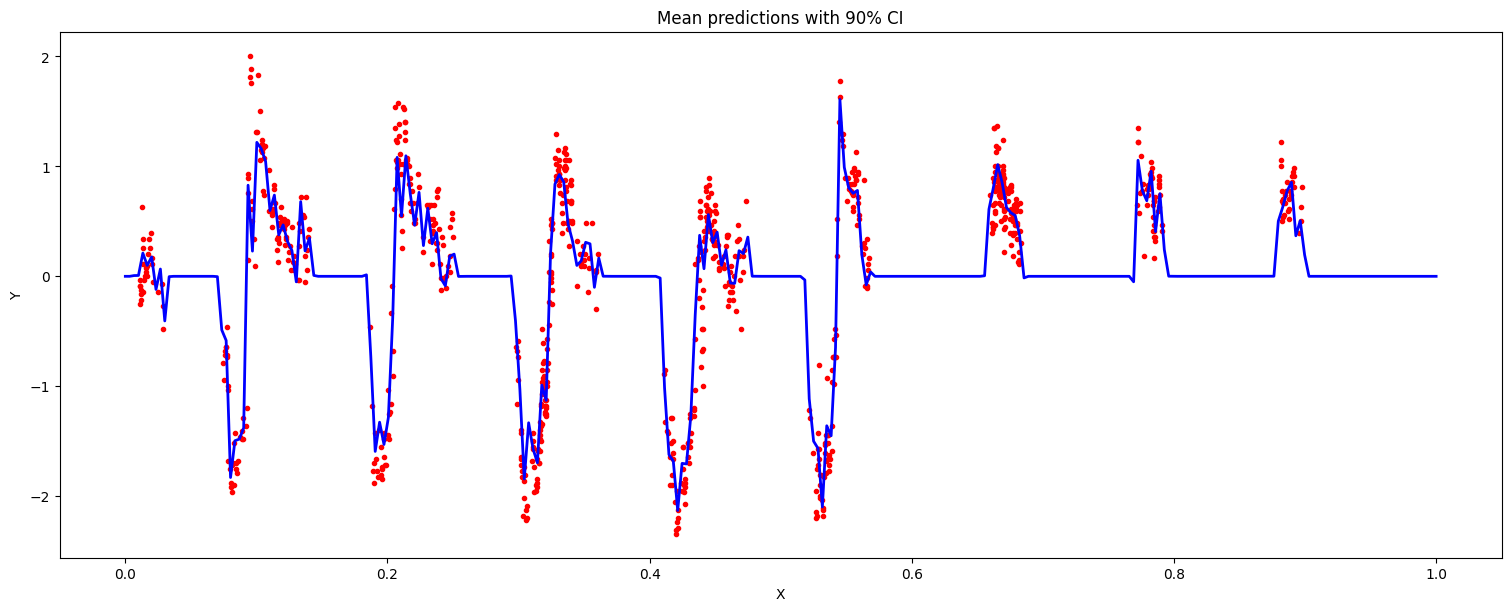

In [439]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
# ax.fill_between(X_test, s2[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, m1, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");


In [430]:
l2 = samples['kernel_length2'].mean()
v2 = samples['kernel_var2'].mean()
n2 = samples['kernel_noise2'].mean()

In [440]:
l2

DeviceArray(0.10346517, dtype=float32)

In [433]:
key1, key2 = random.split(rng_key)
m2, s2 = predict(key1, X2, Y, X_test, v2, l2, n2,)

In [444]:
p2 = onp.percentile(s2, [5.0, 95.0], axis=0)

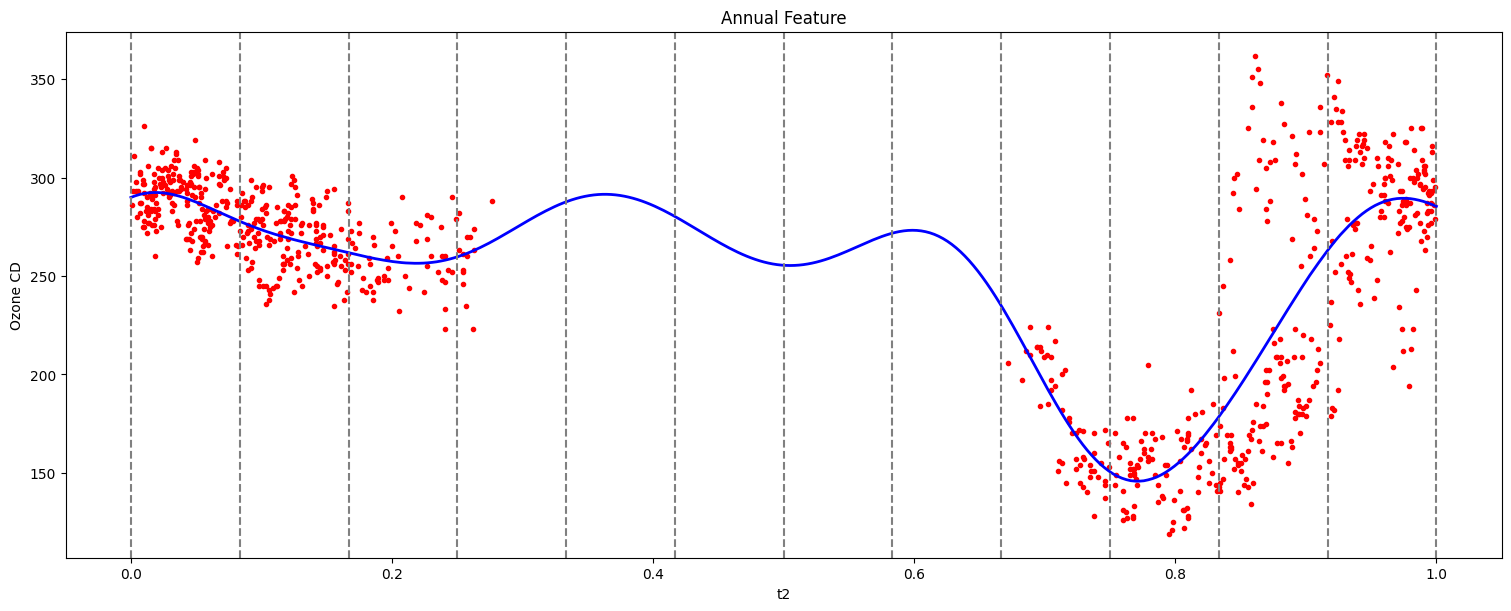

In [453]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X2, Y*train.std()+train.mean(), "r.")
# plot 90% confidence level of predictions
# ax.fill_between(X_test, s2[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, m2*train.std()+train.mean(), "blue", ls="solid", lw=2.0)
# ax.fill_between(X_test, p2[0, :], p2[1, :], color="lightblue")

ax.set(xlabel="t2", ylabel="Ozone CD", title="Annual Feature");

for p in np.arange(0,1.+1/12,1/12):
    ax.axvline(p, color = 'gray', linestyle = '--')


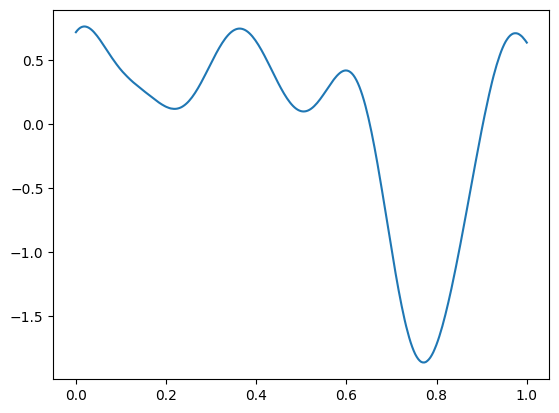

In [434]:
plt.plot(X_test ,m2)

In [426]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var2"].shape[0]),
     samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"]
)

means_t2, predictions_t2 = vmap(
    lambda rng_key, var1, length1, noise1: \
    predict(rng_key, X2, Y, X_test, var1, length1, noise1,)
)(*vmap_args)

mean_prediction_t2 = onp.mean(means_t2, axis=0)
percentiles_t2 = onp.percentile(predictions_t2, [5.0, 95.0], axis=0)

CPU times: user 1min 7s, sys: 33.6 s, total: 1min 41s
Wall time: 23.1 s


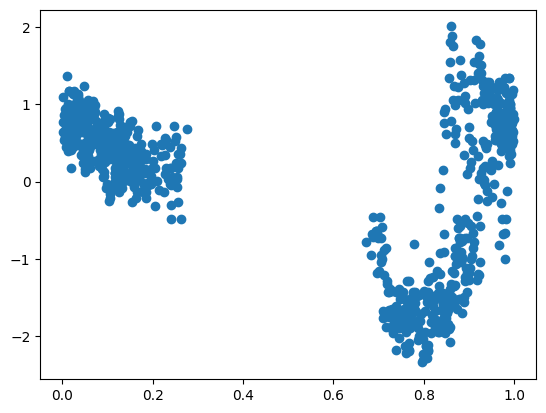

In [428]:
plt.scatter(X2, Y)

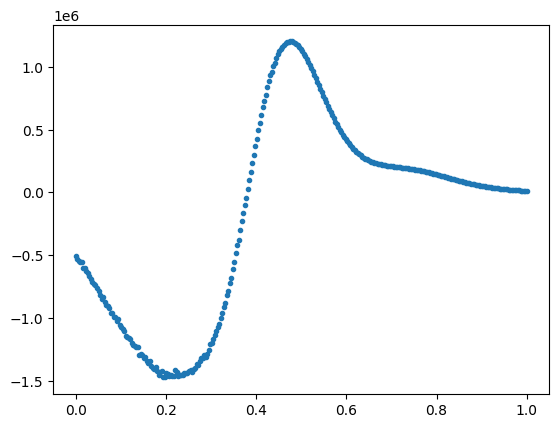

In [427]:
plt.plot(X_test, mean_prediction_t2, '.')

In [445]:
percentiles.shape

(2, 300)

In [446]:
p2.shape

(2,)

In [ ]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

ax.axhline(0, linestyle = '--', color = 'k', linewidth = '.5')



for x in np.arange(0, 1., dt_year):
    ax.axvline(x, color = 'black', linestyle = '-', linewidth = 1.2)
    
ax.set_xticks(np.arange(0.,1.1,.05));


In [323]:
t0 = np.linspace(0,1,100)
t2 = t0*dt_year

In [324]:
t1 = onp.array([i*dt_year+t2 for i in range(9)]).flatten()

In [325]:
t1.shape

(900,)

In [311]:
t2.shape

(300,)

In [326]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"],
    samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)

means_q, predictions_q = vmap(
    lambda rng_key, var1, length1, noise1, var2, length2, noise2: predict2(
        rng_key, X, Y, t1, var1, length1, noise1, var2, length2, noise2
    )
)(*vmap_args)

mean_prediction_q = onp.mean(means_q, axis=0)
percentiles_q = onp.percentile(predictions_q, [5.0, 95.0], axis=0)

CPU times: user 2min 28s, sys: 2min 11s, total: 4min 39s
Wall time: 1min 15s


In [327]:
mean_prediction_q.shape

(900,)

In [314]:
X.shape

(847,)

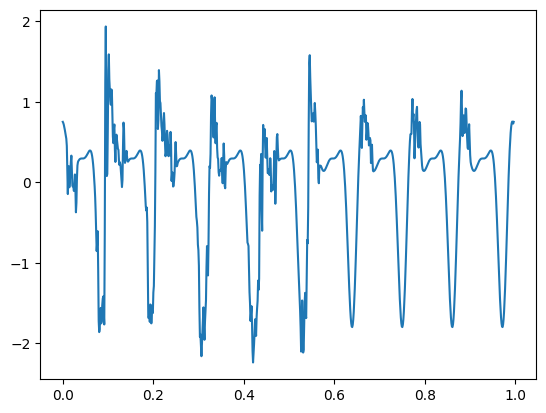

In [328]:
plt.plot(t1, mean_prediction_q)

In [278]:
X_test2 = X_test/dt_year-(X_test//dt_year)

In [372]:
mean_prediction_q[:99].shape, t0.shape

((99,), (100,))

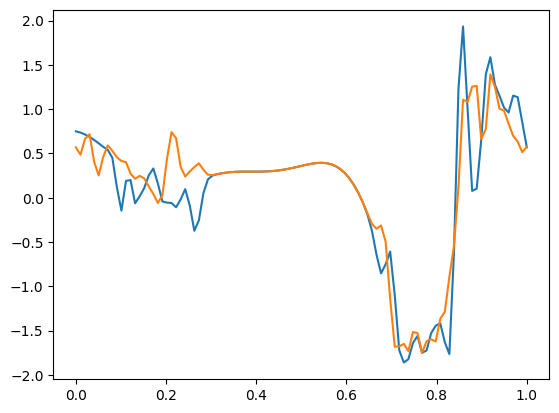

In [375]:
plt.plot(t0, mean_prediction_q[:100])
plt.plot(t0, mean_prediction_q[100:200])

In [266]:
dt_year

0.11070559610705594

In [376]:
mpq = mean_prediction_q.reshape(-1, 100)

In [382]:
mpq.shape

(9, 100)

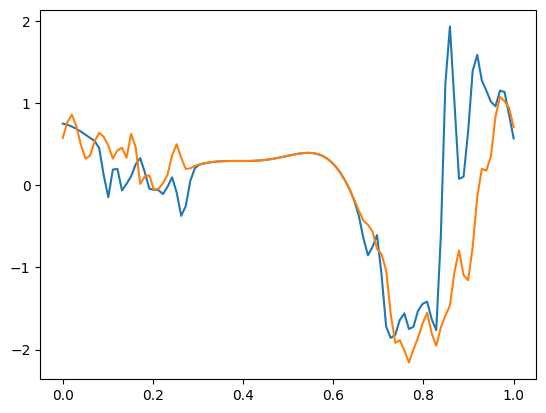

In [379]:
plt.plot(t0, mean_prediction_q[:100])
plt.plot(t0, mpq[2])

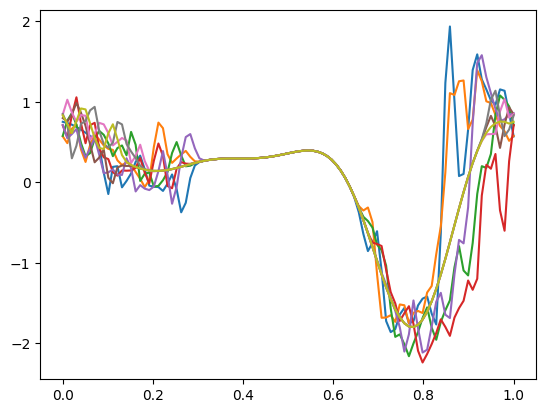

In [381]:
plt.plot(t0, mpq.T);

In [387]:
train = df['x'].to_numpy()[::4]

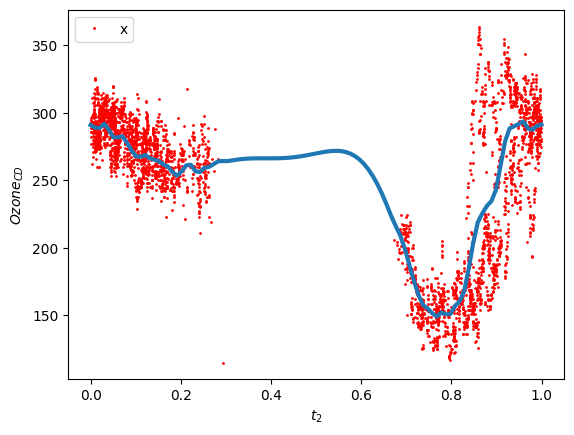

In [404]:
ax = df.plot('reg_year_dtab','x', style = 'o', ms = 1, color = 'r')
ax.plot(t0, mpq.mean(axis = 0)*train.std()+train.mean(), linewidth = 3, color = 'tab:blue')
ax.set_xlabel('$t_2$')
ax.set_ylabel('${Ozone}_{CD}$');

-2.5166802919484068e-17

In [275]:
.1/dt_year-(.1//dt_year)

0.9032967032967035

In [346]:
an.query('year==1').t2.to_numpy()-an.query('year==2').t2.to_numpy()

ValueError: operands could not be broadcast together with shapes (100,) (102,) 

DeviceArray([0.        , 0.01020408, 0.02040816, 0.03061225, 0.04081633,
             0.05102041, 0.06122449, 0.07142857, 0.08163265, 0.09183674,
             0.10204081, 0.1122449 , 0.12244898, 0.13265306, 0.14285713,
             0.15306123, 0.1632653 , 0.17346938, 0.18367347, 0.19387755,
             0.20408162, 0.21428572, 0.2244898 , 0.23469387, 0.24489796,
             0.25510204, 0.26530612, 0.2755102 , 0.28571427, 0.29591838,
             0.30612245, 0.31632653, 0.3265306 , 0.33673468, 0.34693876,
             0.35714284, 0.36734694, 0.37755102, 0.3877551 , 0.39795917,
             0.40816325, 0.41836733, 0.42857143, 0.4387755 , 0.4489796 ,
             0.45918366, 0.46938774, 0.47959182, 0.48979592, 0.5       ,
             0.5102041 , 0.52040815, 0.53061223, 0.5408163 , 0.5510204 ,
             0.56122446, 0.57142854, 0.5816326 , 0.59183675, 0.6020408 ,
             0.6122449 , 0.622449  , 0.63265306, 0.64285713, 0.6530612 ,
             0.6632653 , 0.67346936, 0.68367344, 0.

In [338]:
an.query('year==1').t2

99     0.000000
100    0.000000
101    0.010101
102    0.020202
103    0.030303
         ...   
194    0.949495
195    0.959596
196    0.969697
197    0.979798
198    0.989899
Name: t2, Length: 100, dtype: float32

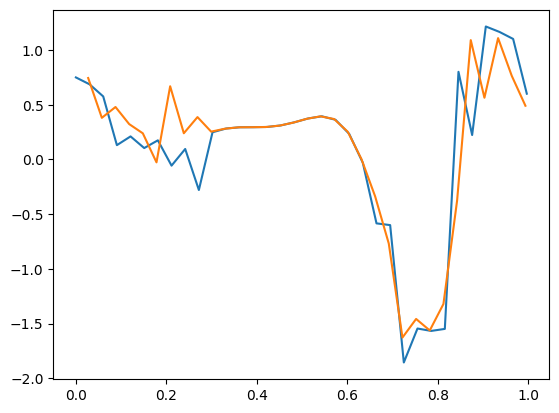

In [291]:
plt.plot(an.query('year==0').t2, an.query('year==0').pred)
plt.plot(an.query('year==1').t2, an.query('year==1').pred)

In [290]:
an.query('year==1').t2.to_numpy()

array([0.02716005, 0.05737066, 0.08758128, 0.11779189, 0.1480025 ,
       0.178213  , 0.20842361, 0.23863423, 0.26884484, 0.29905534,
       0.32926607, 0.35947657, 0.3896873 , 0.4198978 , 0.4501083 ,
       0.48031902, 0.5105295 , 0.54074013, 0.57095075, 0.60116136,
       0.63137186, 0.6615826 , 0.6917931 , 0.7220036 , 0.7522143 ,
       0.7824248 , 0.81263554, 0.84284604, 0.87305665, 0.90326726,
       0.9334779 , 0.9636884 , 0.993899  ], dtype=float32)

In [289]:
an.query('year==2').t2.to_numpy()

array([0.0241096 , 0.0543201 , 0.08453083, 0.11474133, 0.14495206,
       0.17516255, 0.20537305, 0.23558378, 0.26579428, 0.296005  ,
       0.3262155 , 0.356426  , 0.38663673, 0.41684723, 0.44705796,
       0.47726846, 0.5074792 , 0.5376897 , 0.5679002 , 0.5981107 ,
       0.6283214 , 0.65853214, 0.68874264, 0.71895313, 0.7491636 ,
       0.7793746 , 0.8095851 , 0.8397956 , 0.8700061 , 0.9002166 ,
       0.9304273 , 0.96063805, 0.99084854], dtype=float32)

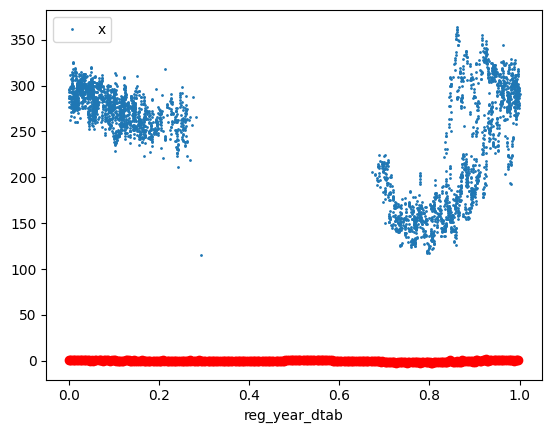

In [263]:
ax = df.plot('reg_year_dtab','x', style = 'o', ms = 1)
ax.scatter(X_test2, mean_prediction, color = 'r')